In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
train_images = train_images.reshape((60000, 28,28, 1))
train_images = train_images.astype('float32')/ 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32')/255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [4]:
# Model architecture
def build_CNN():

    # Convolutional NN
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,28,1)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    # Adding a NN Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(10, activation = 'softmax'))

    # Compile model
    model.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy', 'mae'])

    return model

In [5]:
model = build_CNN()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [6]:
model.fit(train_images, train_labels, epochs = 5, batch_size = 64)

Epoch 1/5
938/938 [==============================] - 17s 18ms/step - loss: 0.1690 - accuracy: 0.9459 - mae: 0.0168
Epoch 2/5
938/938 [==============================] - 16s 18ms/step - loss: 0.0468 - accuracy: 0.9854 - mae: 0.0044
Epoch 3/5
938/938 [==============================] - 17s 18ms/step - loss: 0.0310 - accuracy: 0.9900 - mae: 0.0029
Epoch 4/5
938/938 [==============================] - 37s 39ms/step - loss: 0.0242 - accuracy: 0.9927 - mae: 0.0022
Epoch 5/5
938/938 [==============================] - 23s 25ms/step - loss: 0.0191 - accuracy: 0.9937 - mae: 0.0017


In [7]:
# Perform k-fold cross-validation to understand the optimal number of epochs to train on
k = 4
num_val_samples = len(train_images)//k

num_epochs = 20

all_val_mae_histories = []
all_train_mae_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    model = build_CNN()
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    print(history.history.keys())
    
    val_mae_history = history.history['val_mae']
    all_val_mae_histories.append(val_mae_history)
    
    train_mae_history = history.history['mae']
    all_train_mae_histories.append(train_mae_history)

processing fold # 0
dict_keys(['loss', 'accuracy', 'mae', 'val_loss', 'val_accuracy', 'val_mae'])
processing fold # 1
dict_keys(['loss', 'accuracy', 'mae', 'val_loss', 'val_accuracy', 'val_mae'])
processing fold # 2
dict_keys(['loss', 'accuracy', 'mae', 'val_loss', 'val_accuracy', 'val_mae'])
processing fold # 3
dict_keys(['loss', 'accuracy', 'mae', 'val_loss', 'val_accuracy', 'val_mae'])


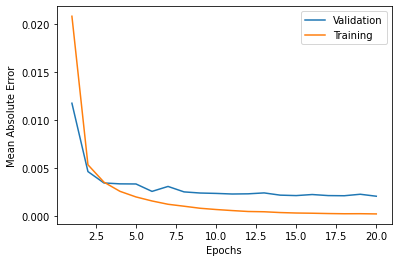

<Figure size 432x288 with 0 Axes>

In [9]:
# Compute the average of the per-epoch MAE scores for all folds
# Building the history of successive mean K-fold validation scores

average_val_mae_history = [
    np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

average_train_mae_history = [
    np.mean([x[i] for x in all_train_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_val_mae_history) + 1), average_val_mae_history, label='Validation')
plt.plot(range(1, len(average_train_mae_history) + 1), average_train_mae_history, label = 'Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()
plt.savefig('Chollet_Baseline_CNN.png')

In [17]:
test = model.evaluate(test_images, test_labels)
test

313/313 [==============================] - 1s 2ms/step - loss: 0.0459 - accuracy: 0.9858 - mae: 0.0037


[0.04592744633555412, 0.98580002784729, 0.0036971985828131437]